In [1]:
from datetime import datetime
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

modelpath = r'F:\nllb-gos\hfacemodels'
modelname = 'facebook/nllb-200-distilled-1.3B' # 3.3B might be too big for my puny 3060 12GB (1.3B was too big for 1660ti). Might also be worse if it's not distilled.

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_SAVE_PATH = f'../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-{timestamp}'
print(MODEL_SAVE_PATH)

../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-20250202-115506


## 1. Exploring the data

In this section, I try to understand what is the training data that I have, and how suitable it is for fine-tuning a NLLB model.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Define language codes
source_langs = ["nld", 'gos']#"eng", "deu", "gos"]#, "spa", "afr", "dan"]
target_langs = source_langs # ["gos"]
new_lang_long = "gos_Latn"

class ParallelCorpus:
    def __init__(self, source_lang, target_lang):
        self.source_lang = source_lang
        self.target_lang = target_lang
        self.source_lang_long = source_lang+'_Latn'
        self.target_lang_long = target_lang+'_Latn'
        
        # Load the parallel sentences for the given language pair
        self.df = self.load_and_format_parallel_sentences()
        
        # Split the data into train, validation, and test sets
        self.df_train, self.df_temp = train_test_split(self.df, test_size=0.02, random_state=9358)
        self.df_validate, self.df_test = train_test_split(self.df_temp, test_size=0.5, random_state=9358)
        
        # Clean up temporary DataFrame
        del self.df_temp

    def load_and_format_parallel_sentences(self):
        # Load sentences for the source and target language
        source_sentences = pd.read_csv(
            f"../tatoeba/{self.source_lang}_sentences.tsv", 
            sep="\t", header=None, names=["id", "language", "source_sentence"]
        )
        target_sentences = pd.read_csv(
            f"../tatoeba/{self.target_lang}_sentences.tsv", 
            sep="\t", header=None, names=["id", "language", "target_sentence"]
        )
        
        # Load links
        link_sentences = pd.read_csv(
            "../tatoeba/links.csv", 
            sep="\t", header=None, names=["origin", "translation"]
        )
        
        # Merge datasets to create parallel sentence pairs
        df_parallel = link_sentences.merge(source_sentences, left_on="origin", right_on="id")\
                                    .merge(target_sentences, left_on="translation", right_on="id")\
                                    [["target_sentence", "source_sentence"]]
        
        # Add source language code
        df_parallel["source_lang_code"] = self.source_lang
        
        return df_parallel

# Create a list of ParallelCorpus instances for each source language
corpus_objects = []
for i, src_lang in tqdm(enumerate(source_langs)):
    for tgt_lang in source_langs[i+1:]:
        print('loading parallel corpus for',src_lang, tgt_lang)
        corpus_objects.append(ParallelCorpus(src_lang, tgt_lang))

# Example: Access the training, validation, and test DataFrames for the first source language in the list
corpus_objects[-1].df_test.sample(4)


0it [00:00, ?it/s]

loading parallel corpus for nld gos


,target_sentence,source_sentence,source_lang_code
10241,k Heb lèst lezen dat verstandskoezen n overbli...,Ik heb onlangs gelezen dat verstandskiezen een...,nld
7808,Hai mòt terogkommen.,Hij moet terugkomen.,nld
2499,Welk spaigelploatje wilst beluustern?,Welke cd wil je beluisteren?,nld
1724,t Is bèrgoanstied.,Het is bedtijd.,nld


# 4. Adding a new language tag to the tokenizer and model

In [3]:
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
from gc import collect
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# we need transformers<=4.33 for this to work.

def fix_tokenizer(tokenizer, new_lang='gos_Latn'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

def cleanup():
    """Try to free GPU memory"""
    collect()
    torch.cuda.empty_cache()

tokenizer = NllbTokenizer.from_pretrained(modelname, cache_dir=modelpath)
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

fix_tokenizer(tokenizer)
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'gos_Latn', '<mask>'])) # [256202, 256203, 256204]

cleanup()
model = AutoModelForSeq2SeqLM.from_pretrained(modelname, cache_dir=modelpath, device_map={"": "cuda:0"})
# for name, module in model.named_modules(): print(name)

added_token_id = tokenizer.convert_tokens_to_ids(new_lang_long)
#similar_lang_id = tokenizer.convert_tokens_to_ids('fry_Latn')
#similar_lang_id = tokenizer.convert_tokens_to_ids('nds_Latn')
similar_lang_id = tokenizer.convert_tokens_to_ids('nld_Latn')
print(added_token_id, similar_lang_id)

model.resize_token_embeddings(len(tokenizer))

# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

model.resize_token_embeddings(len(tokenizer))

C:\Users\tbran\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['zul_Latn', '<mask>']
['zul_Latn', 'gos_Latn', '<mask>']
[256202, 256203, 256204]


C:\Users\tbran\AppData\Roaming\Python\Python311\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\tbran\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication

256203 256127


Embedding(256205, 1024)

# 5. Preparing the training loop

In [4]:
import random
import numpy as np
from tqdm.auto import  trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup
import sys
import re
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer

model.cuda()

optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

batch_size = 25 # 20 is fine
max_chars = 200 # characters. can be set to None in which case sentences will not be cut at the end. in the future the cutting might be done at the last space/word boundary before max_chars rather than in the middle of a word.
max_length = 99 # tokens
warmup_steps = 100
training_steps = int(3000*8/batch_size) # I thought around int(1200*8/batch_size) was enough but maybe it should go higher. let's do some overfitting investigation.

losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]

def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

def get_batch_pairs(batch_size, dataset="train", max_chars=None, apply_variations=True):
    # Calculate weights based on dataset sizes
    weights = []
    for corp in corpus_objects:
        if dataset == "train":
            weights.append(len(corp.df_train))
        elif dataset == "validate":
            weights.append(len(corp.df_validate))
        elif dataset == "test":
            weights.append(len(corp.df_test))
        else:
            raise ValueError(f"Invalid dataset specified: {dataset}. Choose from 'train', 'validate', or 'test'.")
    
    weights = [w / sum(weights) for w in weights]
    corpus = np.random.choice(corpus_objects, p=weights, replace=False)
    
    # Sample the batch
    if dataset == "train":
        batch = corpus.df_train.sample(n=batch_size)
    elif dataset == "validate":
        batch = corpus.df_validate.sample(n=batch_size)
    elif dataset == "test":
        batch = corpus.df_test.sample(n=batch_size)
    
    # Preprocess sentences
    batch['source_sentence'] = batch['source_sentence'].apply(preproc)
    batch['target_sentence'] = batch['target_sentence'].apply(preproc)
    
    source_lang_long = corpus.source_lang_long
    target_lang_long = corpus.target_lang_long
    
    xx = batch['source_sentence'].tolist()
    yy = batch['target_sentence'].tolist()
    
    # Optional: Apply variations
    if apply_variations:
        xx, yy = add_data_variations(xx, yy, source_lang_long, target_lang_long, batch_size)
    
    # Trim sentences if max_chars is specified
    if max_chars:
        def truncate_at_space(sent, max_len):
            if len(sent) <= max_len:
                return sent
            # Find the last space before max_len
            truncate = sent[:max_len]
            return truncate[:truncate.rfind(" ")]
        xx = [truncate_at_space(x, max_chars) for x in xx]
        yy = [truncate_at_space(y, max_chars) for y in yy]
    
    return xx, yy, source_lang_long, target_lang_long

def add_gronings_variations(sentences):
    # Gronings-specific removal of more or less optional diacritics
    if not random.getrandbits(2):
        sentences = [s.replace('ì', 'i').replace('è', 'e').replace('ò', 'o').replace('ó', 'o') for s in sentences]
    return sentences

# List of synonym pairs
synonym_pairs_gos = [
    ('huus', 'hoes'), ('huzen', 'hoezen'), ('huuske', 'hoeske'), ('groag', 'geern'), ('raais', 'raaize'), ('kees', 'keze'), ('week', 'weke'),
    ('mìnsken', 'mìnsen'), ('uut', 'oet'), ('in', 'ien'), ('wer', 'wuir'), ('gebruuk', 'gebroek'), ('zuch', 'zok'), ('bruukst', 'broekst'), ('wind', 'wiend'),
    ('vanuut', 'vanoet'), ('wazzen', 'waren'), ('mekoar', 'nkander'), ('bruken', 'broeken'), ('zuch', 'zuk'), ('vis', 'visk'), ('olle', 'olde'),
    ('zuk', 'zok'), ('wotter', 'woater'), ('kraant', 'kraande'), ('haar', 'har'), ('bruuk', 'broek'), ('school', 'schoule'), ('iezer', 'iesder'),
    ('ais', 'ains'), ('hebben', 'hemmen'), ('zotterdag', 'zoaterdag'), ('bruukt', 'broekt'), ('bruukten', 'broekten'), ('iezern', 'iesdern'), ('kind', 'kiend'),
    ('mirreg', 'middag'), ('vast', 'vaast'), ('nacht', 'naacht'), ('kiender', 'kinder'), ('bruukte', 'broekte'), ('deus','deuze'), ('gelok', 'geluk')
]

def swap_synonyms(sentences, synonym_pairs, swap_prob=0.25):
    swapped_sentences = []

    for sent in sentences:
        words = sent.split()  # Split sentence into words
        new_words = []
        
        for word in words:
            replaced = False
            
            # Check each synonym pair
            for word1, word2 in synonym_pairs:
                if word == word1 and random.random() < swap_prob:
                    # print(sent)
                    new_words.append(word2)  # Replace with the second variant
                    replaced = True
                    break
                elif word == word2 and random.random() < swap_prob:
                    new_words.append(word1)  # Replace with the first variant
                    replaced = True
                    break
            
            if not replaced:
                new_words.append(word)  # Keep the original word if not replaced
        
        # Reconstruct the sentence
        swapped_sentences.append(' '.join(new_words))
    
    return swapped_sentences


def add_data_variations(xx, yy, source_lang_long, target_lang_long, batch_size):
    # Randomly swap source and target languages
    if random.getrandbits(1):
        xx, yy, source_lang_long, target_lang_long = yy, xx, target_lang_long, source_lang_long

    if target_lang_long == 'gos_Latn':
        yy = add_gronings_variations(yy)
        yy = swap_synonyms(yy, synonym_pairs_gos)
    elif source_lang_long == 'gos_Latn':
        xx = add_gronings_variations(xx)
        xx = swap_synonyms(xx, synonym_pairs_gos)

    # Create more name variation (e.g., replacing "Tom")
    for i in range(len(xx)):
        if "Tom" in xx[i] and "Tom" in yy[i]:
            namelist = ['Tim', 'Sam', 'Ben', 'Nick', 'Ed', 'Noah', 'Joey', 'Rick', 'Rob', 'Mick', 'Mike', 'Michael', 'Tom', 'Adam', 'Arnold', 'Lucas', 'Robin', 'James', 'Jim']
            othername = random.choice(namelist)
            xx[i] = xx[i].replace("Tom", othername)
            yy[i] = yy[i].replace("Tom", othername)

    # Small chance of uppercase transformation
    if not random.getrandbits(5):
        xx = [x.upper() for x in xx]
        yy = [y.upper() for y in yy]

    # chance of no capitalization at sentence start
    elif not random.getrandbits(3):
        xx = [x[:1].lower() + x[1:] for x in xx]
        yy = [y[:1].lower() + y[1:] for y in yy]

    # Small chance of random emoji at the end
    if not random.getrandbits(3):
        emojis = random.choices(["😊", "😂", "😍", "👍", "🔥", "🎉", "🌟", "😎", "🥳", '❤️', '💀', '😭', '🫶', '🤣', '😘', '🥺', '🤔', '🙏'], k=batch_size)
        xx = [xx[i] + emojis[i] for i in range(batch_size)]
        yy = [yy[i] + emojis[i] for i in range(batch_size)]

    # Small chance of sentence-final character deletion
    elif not random.getrandbits(3):
        xx = [x[:-1] if len(x) > 1 else x for x in xx]
        yy = [y[:-1] if len(y) > 1 else y for y in yy]

    return xx, yy

get_batch_pairs(20, dataset='train', max_chars=220);

## 6. The training loop

In [5]:
# model.train()
# x, y, loss = None, None, None
# cleanup()

# max_length = 90
# max_chars = 120
# batch_size = 20
# xx, yy, lang1, lang2 = get_batch_pairs(batch_size)#, max_chars=max_chars)

# tokenizer.src_lang = lang1
# x = tokenizer(xx, return_tensors='pt', padding='longest', truncation=True, max_length=max_length).to(model.device) # max length is a number of tokens.........
# tokenizer.src_lang = lang2
# y = tokenizer(yy, return_tensors='pt', padding='longest', truncation=True, max_length=max_length).to(model.device)
# y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

# loss = model(**x, labels=y.input_ids).loss
# # loss.backward()
# # losses.append(loss.item())

# # optimizer.step()
# # optimizer.zero_grad(set_to_none=True)
# # scheduler.step()

In [6]:
model.train()
x, y, loss = None, None, None
cleanup()
save_and_print_interval = 30

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size, max_chars=max_chars)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding='longest', truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding='longest', truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % save_and_print_interval == 0 and i > 0:
        cleanup()
        print(i, f"mean loss of last {save_and_print_interval} steps:\t", np.mean(losses[-save_and_print_interval:]))
        if i > 0:#1*training_steps/4:
            model.save_pretrained(MODEL_SAVE_PATH+'_'+str(i))
            tokenizer.save_pretrained(MODEL_SAVE_PATH+'_'+str(i))

  0%|          | 0/960 [00:00<?, ?it/s]

25 mean loss of last 25 steps:	 3.77719509601593
50 mean loss of last 25 steps:	 2.811946964263916
75 mean loss of last 25 steps:	 1.9626208233833313
100 mean loss of last 25 steps:	 1.4314152789115906
125 mean loss of last 25 steps:	 1.2980775904655457
150 mean loss of last 25 steps:	 1.2138784503936768
175 mean loss of last 25 steps:	 1.046821038722992
200 mean loss of last 25 steps:	 0.913071129322052
225 mean loss of last 25 steps:	 0.9059874379634857
250 mean loss of last 25 steps:	 0.8453479063510895
275 mean loss of last 25 steps:	 0.7409764367341996
300 mean loss of last 25 steps:	 0.7660100054740906
325 mean loss of last 25 steps:	 0.7126826149225235
350 mean loss of last 25 steps:	 0.7333155870437622
375 mean loss of last 25 steps:	 0.6791268062591552
400 mean loss of last 25 steps:	 0.549078232049942
425 mean loss of last 25 steps:	 0.7364789283275605
450 mean loss of last 25 steps:	 0.574593979716301
475 mean loss of last 25 steps:	 0.5708222591876984
500 mean loss of last 

RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 147456 vs 147350

In [7]:
# Should in near future start saving hyperparameters, something like this:
# # Function to save a model
# def save_model(model, hyperparameters):
#     timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
#     model_folder = f"{MODEL_SAVE_PATH}{timestamp}"
    
#     # Create the folder
#     os.makedirs(model_folder, exist_ok=True)
    
#     # Save the model (this is a placeholder, replace it with actual saving code)
#     model.save(os.path.join(model_folder, 'model.pth'))
    
#     # Save the hyperparameters to a text file
#     with open(os.path.join(model_folder, 'hyperparameters.txt'), 'w') as f:
#         for key, value in hyperparameters.items():
#             f.write(f"{key}: {value}\n")

# # Example usage
# model = None  # Replace with your actual model
# hyperparameters = {'learning_rate': 0.001, 'batch_size': 32}  # Replace with actual hyperparameters
# save_model(model, hyperparameters)

In [11]:
model.save_pretrained(MODEL_SAVE_PATH+'_'+str(training_steps))
tokenizer.save_pretrained(MODEL_SAVE_PATH+'_'+str(training_steps))

('../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-20250202-115506960\\tokenizer_config.json',
 '../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-20250202-115506960\\special_tokens_map.json',
 '../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-20250202-115506960\\sentencepiece.bpe.model',
 '../NLLB-GOS/models/nllb-nld-gos-distilled-1.3B-20250202-115506960\\added_tokens.json')

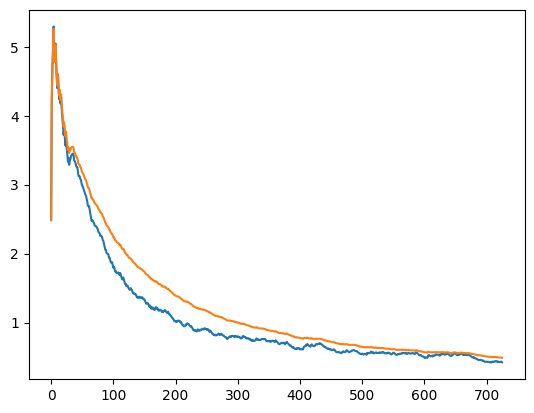

In [10]:
pd.Series(losses).ewm(30).mean().plot();
pd.Series(losses).ewm(100).mean().plot();

In [12]:
def translate(text, src_lang='nld_Latn', tgt_lang='gos_Latn', a=16, b=1.5, max_input_length=700, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [13]:
s = 'De wetenschappers zijn bijna klaar om hun bevindingen te publiceren. Dat zal nog ongeveer een week of dertien kunnen duren. Maar als de resultaten kloppen, zou het universum tien miljard jaar nodig hebben om planeten te vormen. De aarde is nu 4 1⁄2 miljard jaar oud en het universum 15 miljard jaar oud. We zouden dus tot de eerste generatie planeten en überhaupt tot het eerste intelligente leven behoren! Dat vind ik ontzettend indrukwekkend en het houdt me s nachts wakker. De hele nacht lig ik erover te piekeren en vind ik het zo ontzettend bijzonder.'
langA = 'nld_Latn'
langB = 'gos_Latn'
# note it looks like translation between any pairs that don't contain gronings is broken..
print(s)
t = translate(s, langA, langB)
print(t)
t_back = translate(t, langB, langA)
print(t_back)

De wetenschappers zijn bijna klaar om hun bevindingen te publiceren. Dat zal nog ongeveer een week of dertien kunnen duren. Maar als de resultaten kloppen, zou het universum tien miljard jaar nodig hebben om planeten te vormen. De aarde is nu 4 1⁄2 miljard jaar oud en het universum 15 miljard jaar oud. We zouden dus tot de eerste generatie planeten en überhaupt tot het eerste intelligente leven behoren! Dat vind ik ontzettend indrukwekkend en het houdt me s nachts wakker. De hele nacht lig ik erover te piekeren en vind ik het zo ontzettend bijzonder.
['De wezenkers binnen sikkom kloar om heur bevinden te publiceerden. Dat zel nog hailke n week of dattien duurden kinnen. Mor ast de rezeltoaten kloppen, zol t universum tien miljard joar neudeg hebben om planeten te vörmen. De eerde is nou 4 1⁄2 miljard joar old en t universum 15 miljard joar old. Wie zollen dus tot eerste generoatsie planeten en überhaupt tot t eerste intelligente levent tou! Dat vind ik ontzettend in de wegzegen en t ho

In [14]:
from sacrebleu import corpus_bleu, corpus_chrf

# Evaluate translations for validation and training data
results = []

for corpus in tqdm(corpus_objects, desc="Processing corpora"):
    # cleanup()
    # Access validation and training data
    df_validate = corpus.df_validate.sample(n=min(len(corpus.df_validate), 200), random_state=9358)
    df_train_sample = corpus.df_train.sample(n=max([len(df_validate), 200]), random_state=9358)
    
    for dataset_name, dataset in [("validate", df_validate), ("train", df_train_sample)]:
        # Prepare data for translation
        src_sentences = dataset['source_sentence'].tolist()
        tgt_sentences = dataset['target_sentence'].tolist()
        
        # Translate source to target
        translations_src_to_tgt = translate(
            text=src_sentences,
            src_lang=corpus.source_lang_long,
            tgt_lang=corpus.target_lang_long
        )
        
        # Translate target to source
        translations_tgt_to_src = translate(
            text=tgt_sentences,
            src_lang=corpus.target_lang_long,
            tgt_lang=corpus.source_lang_long
        )
        
        # Calculate metrics
        bleu_src_to_tgt = corpus_bleu(tgt_sentences, [translations_src_to_tgt]).score
        bleu_tgt_to_src = corpus_bleu(src_sentences, [translations_tgt_to_src]).score
        
        chrf_src_to_tgt = corpus_chrf(tgt_sentences, [translations_src_to_tgt]).score
        chrf_tgt_to_src = corpus_chrf(src_sentences, [translations_tgt_to_src]).score
        
        # Store results
        results.append({
            "source_lang": corpus.source_lang,
            "target_lang": corpus.target_lang,
            "dataset": dataset_name,
            "bleu_src_to_tgt": bleu_src_to_tgt,
            "bleu_tgt_to_src": bleu_tgt_to_src,
            "chrf_src_to_tgt": chrf_src_to_tgt,
            "chrf_tgt_to_src": chrf_tgt_to_src,
        })

# Convert results to a DataFrame for easier analysis
df_results = pd.DataFrame(results)

Processing corpora:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
pd.set_option('display.precision', 1)
display(df_results)

#####
# After adapting code to sample languages weighted by corpus size, Dutch results look balanced. English seems to still overfit, German probably too.
# Scores from Gronings to the other languages are often higher than the other way around. Don't think it's surprising with a multilingual model.
# A very multilingual model containing Dutch English German Spanish Afrikaans and Danish seems to perform worse on Dutch. But surprisingly good on Danish??? Or maybe that's an artifact of too small validation set..

,source_lang,target_lang,dataset,bleu_src_to_tgt,bleu_tgt_to_src,chrf_src_to_tgt,chrf_tgt_to_src
0,nld,gos,validate,50.3,69.7,71.8,82.2
1,nld,gos,train,58.8,79.8,77.4,87.3


Dutch scores for training on English and German as well:
```
	source_lang	target_lang	dataset		bleu_src_to_tgt	bleu_tgt_to_src	chrf_src_to_tgt	chrf_tgt_to_src
0	nld		gos		validate	38.9		60.4		27.8		24.3
1	nld		gos		train		37.3		60.8		22.3		22.0
```

Scores for just a nld-gos model
tldr all scores are significantly higher. gos to nld bleu improved the least

In [ ]:
# now let's try to investigate overfitting.

import re
import sys
import typing as tp
import unicodedata
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer
from sacremoses import MosesPunctNormalizer
from sacrebleu import corpus_bleu, corpus_chrf

# Preprocessing setup
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]

def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)  # Normalize fancy characters
    return clean

# Function to translate with preprocessing
def translate(text, src_lang, tgt_lang, model, tokenizer):
    # Apply preprocessing to the text
    preprocessed_text = [preproc(sentence) for sentence in text]

    tokenizer.src_lang = src_lang
    inputs = tokenizer(preprocessed_text, return_tensors="pt", padding=True, truncation=True).to(model.device)
    outputs = model.generate(**inputs)
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

def fix_tokenizer(tokenizer, new_lang='gos_Latn'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

# Model loading and evaluation
def load_and_evaluate_model(version_path, corpus_objects):
    model = AutoModelForSeq2SeqLM.from_pretrained(version_path).cuda()
    tokenizer = NllbTokenizer.from_pretrained(version_path)

    fix_tokenizer(tokenizer)
    model.resize_token_embeddings(len(tokenizer))

    results = []
    for corpus in corpus_objects:
        # Access validation data
        df_validate = corpus.df_validate.sample(n=min(len(corpus.df_validate), 200), random_state=9358)
        src_val_sentences = df_validate['source_sentence'].tolist()
        tgt_val_sentences = df_validate['target_sentence'].tolist()
        
        # Access training data (sample 3x size of validation set to save compute)
        train_sample_size = min(len(corpus.df_train), 3 * len(df_validate))
        df_train = corpus.df_train.sample(n=train_sample_size, random_state=9358)
        src_train_sentences = df_train['source_sentence'].tolist()
        tgt_train_sentences = df_train['target_sentence'].tolist()
        
        # Translate validation set
        translations_src_to_tgt_val = translate(
            text=src_val_sentences,
            src_lang=corpus.source_lang_long,
            tgt_lang=corpus.target_lang_long,
            model=model,
            tokenizer=tokenizer
        )

        translations_tgt_to_src_val = translate(
            text=tgt_val_sentences,
            src_lang=corpus.target_lang_long,
            tgt_lang=corpus.source_lang_long,
            model=model,
            tokenizer=tokenizer
        )

        # Translate training set
        translations_src_to_tgt_train = translate(
            text=src_train_sentences,
            src_lang=corpus.source_lang_long,
            tgt_lang=corpus.target_lang_long,
            model=model,
            tokenizer=tokenizer
        )

        translations_tgt_to_src_train = translate(
            text=tgt_train_sentences,
            src_lang=corpus.target_lang_long,
            tgt_lang=corpus.source_lang_long,
            model=model,
            tokenizer=tokenizer
        )

        # Calculate BLEU and CHRF metrics
        bleu_src_to_tgt_val = corpus_bleu(tgt_val_sentences, [translations_src_to_tgt_val]).score
        bleu_tgt_to_src_val = corpus_bleu(src_val_sentences, [translations_tgt_to_src_val]).score

        chrf_src_to_tgt_val = corpus_chrf(tgt_val_sentences, [translations_src_to_tgt_val]).score
        chrf_tgt_to_src_val = corpus_chrf(src_val_sentences, [translations_tgt_to_src_val]).score

        bleu_src_to_tgt_train = corpus_bleu(tgt_train_sentences, [translations_src_to_tgt_train]).score
        bleu_tgt_to_src_train = corpus_bleu(src_train_sentences, [translations_tgt_to_src_train]).score

        chrf_src_to_tgt_train = corpus_chrf(tgt_train_sentences, [translations_src_to_tgt_train]).score
        chrf_tgt_to_src_train = corpus_chrf(src_train_sentences, [translations_tgt_to_src_train]).score

        results.append({
            "bleu_src_to_tgt_val": bleu_src_to_tgt_val,
            "bleu_tgt_to_src_val": bleu_tgt_to_src_val,
            "chrf_src_to_tgt_val": chrf_src_to_tgt_val,
            "chrf_tgt_to_src_val": chrf_tgt_to_src_val,
            "bleu_src_to_tgt_train": bleu_src_to_tgt_train,
            "bleu_tgt_to_src_train": bleu_tgt_to_src_train,
            "chrf_src_to_tgt_train": chrf_src_to_tgt_train,
            "chrf_tgt_to_src_train": chrf_tgt_to_src_train,
        })
    
    return results

import os

# Define the base directory containing the model folders
MODEL_BASE_PATH = '../NLLB-GOS/models/'

# Filter for directories containing "MODEL_BASE_PATH" in their name
model_versions = [folder_name for folder_name in os.listdir(MODEL_BASE_PATH) if MODEL_SAVE_PATH[len(MODEL_BASE_PATH):] in folder_name]

for path in model_versions:
    print(path)

# Evaluate all versions
all_results = {}
for model_name in model_versions:
    if MODEL_BASE_PATH+model_name != MODEL_SAVE_PATH:
        step = model_name.split('_')[-1]
    else:
        print(model_name,'!')
        step = training_steps
    print(f"Evaluating model saved at step {step}...")
    version_results = load_and_evaluate_model(MODEL_BASE_PATH+model_name, corpus_objects)
    
    avg_results = pd.DataFrame(version_results).mean().to_dict()  # Average scores
    all_results[step] = avg_results

# Convert results to a DataFrame
df_results = pd.DataFrame.from_dict(all_results, orient="index")
df_results.index.name = "Training Steps"
df_results.reset_index(inplace=True)
df_results.to_csv(f'overfitting investigation {timestamp}.csv')

nllb-nld-gos-distilled-1.3B-20250202-115506100
nllb-nld-gos-distilled-1.3B-20250202-115506125
nllb-nld-gos-distilled-1.3B-20250202-115506150
nllb-nld-gos-distilled-1.3B-20250202-115506175
nllb-nld-gos-distilled-1.3B-20250202-115506200
nllb-nld-gos-distilled-1.3B-20250202-115506225
nllb-nld-gos-distilled-1.3B-20250202-11550625
nllb-nld-gos-distilled-1.3B-20250202-115506250
nllb-nld-gos-distilled-1.3B-20250202-115506275
nllb-nld-gos-distilled-1.3B-20250202-115506300
nllb-nld-gos-distilled-1.3B-20250202-115506325
nllb-nld-gos-distilled-1.3B-20250202-115506350
nllb-nld-gos-distilled-1.3B-20250202-115506375
nllb-nld-gos-distilled-1.3B-20250202-115506400
nllb-nld-gos-distilled-1.3B-20250202-115506425
nllb-nld-gos-distilled-1.3B-20250202-115506450
nllb-nld-gos-distilled-1.3B-20250202-115506475
nllb-nld-gos-distilled-1.3B-20250202-11550650
nllb-nld-gos-distilled-1.3B-20250202-115506500
nllb-nld-gos-distilled-1.3B-20250202-115506525
nllb-nld-gos-distilled-1.3B-20250202-115506550
nllb-nld-gos-di

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 125...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 150...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 175...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 200...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 225...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 625...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 250...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 275...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 300...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 325...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 350...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 375...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 400...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 425...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 450...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 475...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 650...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 500...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 525...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 550...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 575...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 600...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 625...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 650...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 675...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 700...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 725...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Evaluating model saved at step 675...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


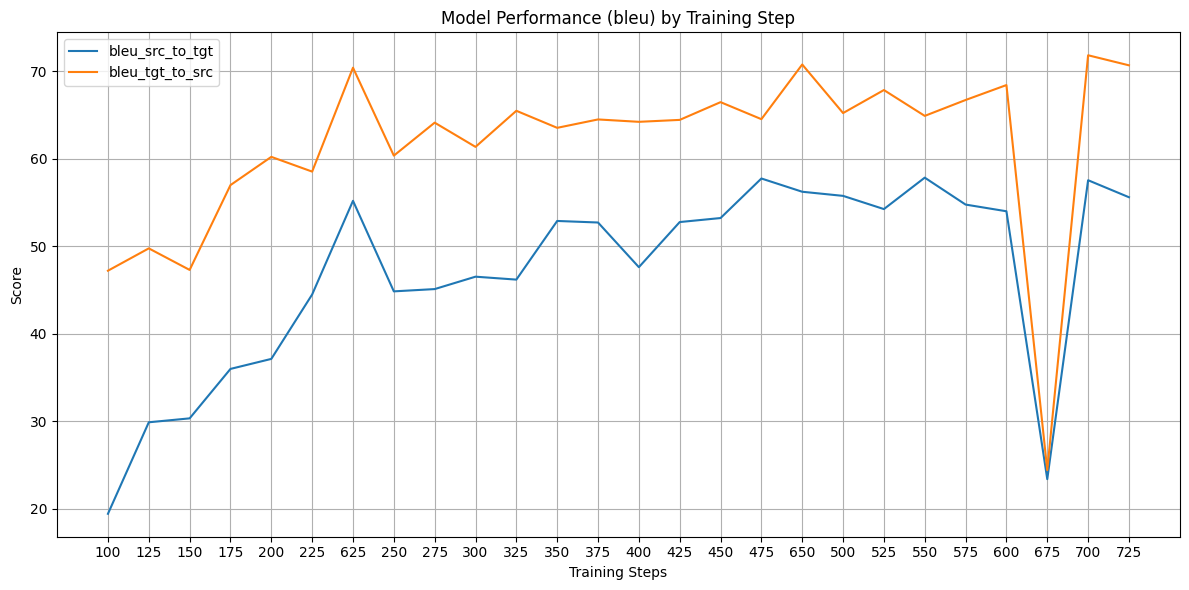

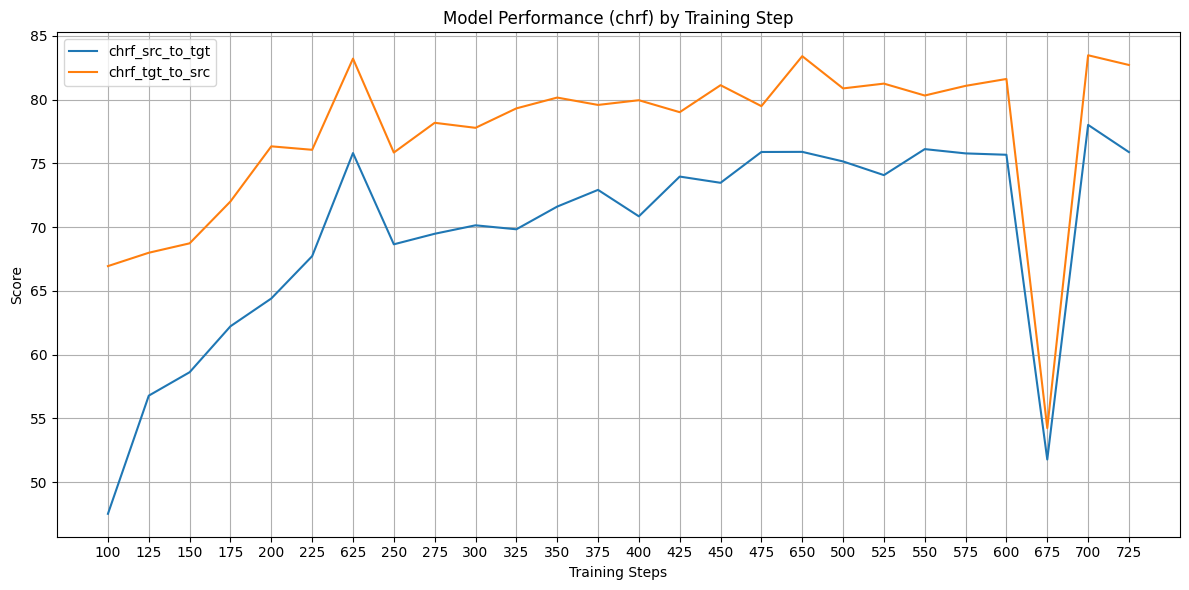

In [18]:
import matplotlib.pyplot as plt

# Plot results
plt.figure(figsize=(12, 6))
metrics = ["bleu_src_to_tgt", "bleu_tgt_to_src"]
for metric in metrics:
    plt.plot(df_results["Training Steps"], df_results[metric], label=metric)

plt.xlabel("Training Steps")
plt.ylabel("Score")
plt.title("Model Performance (bleu) by Training Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
metrics = ["chrf_src_to_tgt", "chrf_tgt_to_src"]
for metric in metrics:
    plt.plot(df_results["Training Steps"], df_results[metric], label=metric)

plt.xlabel("Training Steps")
plt.ylabel("Score")
plt.title("Model Performance (chrf) by Training Step")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
1/0

## 7. Using the model

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [4]:
# this code is adapted from the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
model_load_name = MODEL_SAVE_PATH
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)

In [ ]:
def fix_tokenizer(tokenizer, new_lang='gos_Latn'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

fix_tokenizer(tokenizer)

model.resize_token_embeddings(len(tokenizer))

In [7]:
def translate(text, src_lang='nld_Latn', tgt_lang='gos_Latn', a=16, b=1.5, max_input_length=700, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
t = 'wie springen op en del.'
print(translate(t, 'gos_Latn', 'nld_Latn'))

In [ ]:
translate(t, 'nld_Latn', 'gos_Latn', do_sample=True, num_beams=2, temperature=1.5)

In [ ]:
gosdemo = pd.read_csv('../gos-kdl/texts.csv')
target_lang = "nld_Latn"
batch_size = 16
translations = []
for i in tqdm(range(0, len(gosdemo), batch_size), desc="Translating batches"):
    batch = gosdemo["text"].tolist()[i:i + batch_size]
    translations.extend(translate(batch, src_lang="gos_Latn", tgt_lang=target_lang))

gosdemo[f"translation_to_{target_lang}"] = translations

# for d in ['ö','ò','ó','ô','è','ì','ë','wui ']:
#     # print(d)
#     for i in gosdemo.iterrows():
#         # print(i)
#         for txt in gosdemo['text']:
#             if d in txt:
#                 print(txt)

In [ ]:
pd.set_option('display.max_colwidth', None)
display(gosdemo[['text','translation_to_nld_Latn']].sample(20))

In [ ]:
df_validate['nld_translated'] = [translate(t, 'gos_Latn', 'nld_Latn')[0] for t in tqdm(df_validate.gos)]
df_validate['gos_translated'] = [translate(t, 'nld_Latn', 'gos_Latn')[0] for t in tqdm(df_validate.nld)]

In [ ]:
df_validate.sample(15)

In [38]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [ ]:
!pip install editdistance

In [ ]:
import editdistance

def ed_similarity(text1, text2):
    return max(0, 1 - editdistance.eval(text1, text2) / min(len(text1), len(text2)))

print(ed_similarity('кот', 'собака'))
print(ed_similarity('кот', 'кит'))

In [ ]:
display(pd.Series([ed_similarity(row.nld, row.nld_translated) for row in df_validate.itertuples()]).describe())
display(pd.Series([ed_similarity(row.gos, row.gos_translated) for row in df_validate.itertuples()]).describe())

In [ ]:
print(bleu_calc.corpus_score(df_validate['rus_translated2'].tolist(), [df_validate['ru'].tolist()]))
print(chrf_calc.corpus_score(df_validate['rus_translated2'].tolist(), [df_validate['ru'].tolist()]))
print(bleu_calc.corpus_score(df_validate['tyv_translated2'].tolist(), [df_validate['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_validate['tyv_translated2'].tolist(), [df_validate['tyv'].tolist()]))

In [ ]:
df_validate['rus2eng'] = [translate(t, 'tyv_Cyrl', 'eng_Latn')[0] for t in tqdm(df_validate.tyv)]
df_validate['tyv2eng'] = [translate(t, 'rus_Cyrl', 'eng_Latn')[0] for t in tqdm(df_validate.ru)]

Results with num_beams=1:
```
V1
BLEU = 23.21 51.2/29.1/18.0/11.8 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 47.88
BLEU = 22.03 51.5/29.7/17.9/10.4 (BP = 0.952 ratio = 0.953 hyp_len = 2260 ref_len = 2371)
chrF2++ = 49.37
V2
BLEU = 24.08 50.9/29.5/19.1/12.3 (BP = 0.988 ratio = 0.988 hyp_len = 2297 ref_len = 2324)
chrF2++ = 48.96
BLEU = 22.50 50.5/28.5/17.7/11.1 (BP = 0.974 ratio = 0.974 hyp_len = 2310 ref_len = 2371)
chrF2++ = 48.85
V3
BLEU = 22.25 49.8/27.8/17.2/11.0 (BP = 0.983 ratio = 0.983 hyp_len = 2284 ref_len = 2324)
chrF2++ = 47.89
BLEU = 25.28 52.2/31.2/20.0/13.1 (BP = 0.989 ratio = 0.989 hyp_len = 2346 ref_len = 2371)
chrF2++ = 51.87
````

Results with 4 beams:
```
V1
BLEU = 24.14 52.5/30.4/18.9/12.1 (BP = 0.981 ratio = 0.981 hyp_len = 2281 ref_len = 2324)
chrF2++ = 49.49
BLEU = 23.41 52.1/31.0/18.9/11.3 (BP = 0.966 ratio = 0.967 hyp_len = 2292 ref_len = 2371)
chrF2++ = 50.89
V2
BLEU = 25.18 52.4/31.3/20.4/13.3 (BP = 0.976 ratio = 0.976 hyp_len = 2269 ref_len = 2324)
chrF2++ = 49.85
BLEU = 23.22 51.6/29.4/18.3/11.6 (BP = 0.975 ratio = 0.975 hyp_len = 2312 ref_len = 2371)
chrF2++ = 49.87
V3
BLEU = 23.06 51.1/29.1/18.1/11.5 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 48.56
BLEU = 26.12 53.4/32.5/21.0/13.6 (BP = 0.985 ratio = 0.985 hyp_len = 2336 ref_len = 2371)
chrF2++ = 52.60
```

Which means:
* For all directions and models, beam search improves the results
* Longer training builds up quality for Tyvan, but decreases it for Russian.

```
                                  | tyv->rus | rus->tyv
Model v1 (no vocabulary update):  |
    no beam search                |   23.21  |  22.03
    num_beams = 4                 |   24.14  |  23.41
Model v2 (with vocabulary update):|
    no beam search                |   24.08  |  22.50
    num_beams = 4                 |   25.18  |  23.22
```

## Publishing the model to HF

In [ ]:
!huggingface-cli login

In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

In [ ]:
upload_repo = "slone/nllb-rus-tyv-v1"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc'
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name + "/pytorch_model_60k.bin", config=cfg)

In [ ]:
upload_repo = "slone/nllb-rus-tyv-v2-extvoc"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

In [ ]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

In [ ]:
MODEL_URL = 'slone/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
tokenizer = NllbTokenizer.from_pretrained(MODEL_URL, force_download=True)
fix_tokenizer(tokenizer)

In [ ]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='rus_Cyrl',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out